# Proyecto de IA - Detección de Música Apta para Niños

Pasos a seguir:

1.   Separar la voz de la música
2.   Obtener la letra de la voz
3.   Procesar la letra para detectar si es apta o no

## Librerías

In [ ]:
# Done
# !pip install -U openai-whisper

In [ ]:
# Done
# !pip install flask-cors

In [ ]:
# Done
# !pip install flask

In [ ]:
# Done
# !pip install torch --user

In [ ]:
# ---- error but it may work
# !pip -q install transformers[torch]

In [ ]:
# Done
# !pip install openunmix

In [ ]:
# Done
# !pip install musdb

In [ ]:
# Done
# !pip install youtube-dl --user


In [ ]:
# Done
# !pip install pydub


In [ ]:
# Done
# !pip install scipy

# tambien instalar "ffmpeg" desde su página web

In [ ]:
# Done
# !pip install stempeg

In [ ]:
# Done
# !pip install setuptools

In [ ]:
# !pip install soundfile

In [ ]:
import torch
import torchaudio
import numpy as np
import scipy
import youtube_dl
import stempeg
import os
# from google.colab import files
from IPython.display import Audio, display
from openunmix import predict
from IPython.display import HTML
from torch import nn, optim
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import textwrap
from pydub import AudioSegment
import whisper
from whisper import load_model, transcribe
import soundfile as sf

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

device

---


---

## Modelo 1 - Open-Unmix

*   Arquitectura: BLSTM
*   Preentrenado con el Dataset: MUSDB18 (https://sigsep.github.io/datasets/musdb.html#musdb18-compressed-stems)
*   Fine-Tunning: Canciones en español con 2 columnas: Canción completa y Canción de solo voz
*   Cuadernillo: https://colab.research.google.com/drive/1mijF0zGWxN-KaxTnd0q6hayAlrID5fEQ
*   Código del Modelo: https://github.com/enricguso/UMX_loss_functions/blob/master/model.py

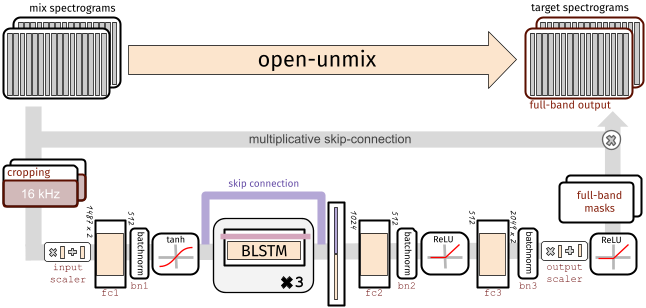

In [ ]:
audio_path = "Dataset de Prueba/1. Calle 13   Latinoamérica.mp3"

# Leer el archivo de audio
audio = AudioSegment.from_file(audio_path)
duration = len(audio) / 1000
stop_test = int(duration)

start = 0
stop = stop_test
# start = 85
# stop = 114

# Leer el archivo de audio
audio_stems, rate = stempeg.read_stems(
    audio_path,
    sample_rate=44100,
    start=start,
    duration=(stop - start),
)

# Asegurarse de que los datos de audio sean válidos
audio_stems = np.nan_to_num(audio_stems)  # Reemplazar NaN por 0 y infinitos por valores finitos grandes

# Escalar los datos de audio al rango [-1, 1]
max_val = np.max(np.abs(audio_stems))
if max_val > 0:
    audio_stems = audio_stems / max_val

# Verificar el rango de los datos de audio
print(f"Audio data range: min = {audio_stems.min()}, max = {audio_stems.max()}")

# Mostrar el audio original
display(Audio(audio_stems.T, rate=rate))

# Realizar la separación
try:
    estimates = predict.separate(
        audio=torch.as_tensor(audio_stems).float(),
        rate=44100,
        targets=['vocals'],
        residual=True,
        device=device
    )
except Exception as e:
    print(f"Error during separation: {e}")
    raise

# Mostrar las estimaciones de las fuentes separadas
for target, estimate in estimates.items():
    print(target)
    
    # Convertir a numpy y verificar valores NaN e Inf
    estimate_np = estimate.detach().cpu().numpy()[0]
    
    # Asegurarse de que no haya valores NaN o infinitos en la estimación
    estimate_np = np.nan_to_num(estimate_np)  # Reemplazar NaN por 0 y infinitos por valores finitos grandes
    
    # Normalizar el rango de -1 a 1
    max_val = np.max(np.abs(estimate_np))
    if max_val > 0:
        estimate_np = estimate_np / max_val
    
    display(Audio(estimate_np, rate=rate))

In [ ]:
# Crear la carpeta si no existe
song_name = os.path.splitext(os.path.basename(audio_path))[0]
output_dir = os.path.join("Separado", song_name)
os.makedirs(output_dir, exist_ok=True)

# Guardar las voces separadas en un archivo
vocals = estimates['vocals'].detach().cpu().numpy()[0]
vocals_path = os.path.join(output_dir, "vocals.wav")
sf.write(vocals_path, vocals.T, rate)  # Guardar el archivo de audio

# Guardar el residual en un archivo
residual = estimates['residual'].detach().cpu().numpy()[0]
residual_path = os.path.join(output_dir, "residual.wav")
sf.write(residual_path, residual.T, rate)  # Guardar el archivo de audio

# Mostrar los archivos de audio guardados
print(f"Archivos de audio guardados en: {output_dir}")

In [ ]:
path_only_voice = vocals_path
path_only_voice

In [ ]:
# Referencia:

# @misc{musdb18,
#   author       = {Rafii, Zafar and
#                   Liutkus, Antoine and
#                   Fabian-Robert St{\"o}ter and
#                   Mimilakis, Stylianos Ioannis and
#                   Bittner, Rachel},
#   title        = {The {MUSDB18} corpus for music separation},
#   month        = dec,
#   year         = 2017,
#   doi          = {10.5281/zenodo.1117372},
#   url          = {https://doi.org/10.5281/zenodo.1117372}
# }


## Modelo 2 - Whisper

*   Repositorio: https://github.com/openai/whisper


In [ ]:
# !pip install -U openai-whisper

# import torch
# import torchaudio
# import numpy as np
# import scipy
# import os
# from google.colab import files
# from IPython.display import Audio, display
# from IPython.display import HTML
# import whisper

# import torch
# from whisper import load_model, transcribe


In [ ]:
# path_only_voice = 'Separado\\1. Calle 13   Latinoamérica\\vocals.wav'

In [ ]:
model = load_model("medium")
# model = load_model("base")

# audio_path = r'/content/drive/MyDrive/Proyecto de IA/1. Open-Unmix/Audio de la separación de canciones/vocals.mp3'
# audio_path = r'/content/drive/MyDrive/Proyecto de IA/1. Open-Unmix/Audio de la separación de canciones/Calle 13 - Latinoamérica (Separado - vocals).mp3'
audio_path = path_only_voice
pred_out = transcribe(model, audio = audio_path, language="es")
print(pred_out["text"])


In [ ]:
# Guardar el texto transcrito en un archivo
path_lyric_txt = os.path.join(output_dir, "Letra.txt")
transcribed_text = pred_out["text"]


with open(path_lyric_txt, 'w', encoding='utf-8') as file:
    file.write(transcribed_text)

print(f'Texto transcrito guardado en {path_lyric_txt}')

## Modelo 3 - Bert

*   Arquitectura: Transformer
*   Fine-Tunning: Letras de canciones que se consideran aptas o no
*   Repositorio: https://colab.research.google.com/drive/1QQ5N1v5FLoXFXMeYHB8wVzvyxNT9X5oA?usp=sharing#scrollTo=t-OS1v4fbiYh

*   https://github.com/dccuchile/beto?tab=readme-ov-file
*   Modelo Específico: Bert - BETO

In [ ]:
# import torch
# from torch import nn, optim
# from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
# from textwrap import wrap

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
path_checkpoint = "Checkpoint/modelo_BETO_ultimo_checkpoint_state_dict.pth"

PRE_TRAINED_MODEL_NAME = 'ignacio-ave/BETO-nlp-sentiment-analysis-spanish'

In [ ]:
category_mapping = {
    '0': 0,
    '1': 1,
}


In [ ]:
class BETOMusicForKidsClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BETOMusicForKidsClassifier, self).__init__()

    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
                        input_ids = input_ids,
                        attention_mask = attention_mask
                        )
    pooled_output = outputs.pooler_output
    drop_output = self.drop(pooled_output)
    output = self.linear(drop_output)
    return output


In [ ]:
# Inicializa el modelo
n_classes = len(category_mapping)
model = BETOMusicForKidsClassifier(n_classes)

# Cargar el state_dict
try:
    checkpoint = torch.load(path_checkpoint, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint)
except Exception as e:
    print(f"Error loading checkpoint: {e}")
    exit(1)

# Mueve el modelo al dispositivo adecuado
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

### Predicción

In [ ]:
# PRE_TRAINED_MODEL_NAME = 'ignacio-ave/BETO-nlp-sentiment-analysis-spanish'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [ ]:
def predict_genre(text, model, tokenizer, device, max_length=200):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, predicted_class = torch.max(outputs, dim=1)

    # Mapear el número de clase predicho al nombre de la categoría correspondiente
    predicted_genre = list(category_mapping.keys())[list(category_mapping.values()).index(predicted_class.item())]
    return predicted_genre

In [ ]:
# Lee el contenido del archivo .txt
with open(path_lyric_txt, 'r', encoding='utf-8') as file:
    transcribed_text = file.read()

# Ajusta el texto transcrito para una impresión más legible
wrapped_lines = textwrap.wrap(transcribed_text, width=70)

# Imprime el contenido del archivo ajustado línea por línea
for line in wrapped_lines:
    print(line)

# Realiza la predicción de género utilizando el texto transcribido
genre = predict_genre(transcribed_text, model, tokenizer, device)
print(f"\n Predicción (0 = No Apta, 1 = Apta): {genre}")

---



---



---

In [ ]:
# Pollitos

test_text = "Los pollitos dicen droga, droga, droga. Cuando tienen hambre Cuando tienen frío"
genre = predict_genre(test_text, model, tokenizer, device)
print("\n".join(wrap(test_text)))
print(f"\nPredicción (0 = No Apta, 1 = Apta): {genre}")


---


---



---




---



---



---



---



---



---

In [ ]:
# !pip install flask

# from flask import Flask, request, jsonify
# import torch
# from torch import nn
# from transformers import BertModel, BertTokenizer
# import os

# app = Flask(__name__)

# # Configuración del modelo y el tokenizador
# PRE_TRAINED_MODEL_NAME = 'ignacio-ave/BETO-nlp-sentiment-analysis-spanish'
# path_checkpoint = "/content/drive/MyDrive/Proyecto de IA/Checkpoints/modelo_BETO_ultimo_checkpoint.pth"
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# category_mapping = {
#     '0': 0,
#     '1': 1,
# }

# class BETOMusicForKidsClassifier(nn.Module):
#     def __init__(self, n_classes):
#         super(BETOMusicForKidsClassifier, self).__init__()
#         self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
#         self.drop = nn.Dropout(p=0.3)
#         self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)

#     def forward(self, input_ids, attention_mask):
#         outputs = self.bert(
#                             input_ids=input_ids,
#                             attention_mask=attention_mask
#                             )
#         pooled_output = outputs.pooler_output
#         drop_output = self.drop(pooled_output)
#         output = self.linear(drop_output)
#         return output

# # Cargar el modelo y el tokenizador
# model = BETOMusicForKidsClassifier(n_classes=2)
# model = torch.load(path_checkpoint)
# # model.load_state_dict(torch.load(path_checkpoint, map_location=device))
# model = model.to(device)
# model.eval()

# tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# def predict_genre(text, model, tokenizer, device, max_length=200):
#     encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
#     input_ids = encoding['input_ids'].to(device)
#     attention_mask = encoding['attention_mask'].to(device)

#     with torch.no_grad():
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         _, predicted_class = torch.max(outputs, dim=1)

#     predicted_genre = list(category_mapping.keys())[list(category_mapping.values()).index(predicted_class.item())]
#     return predicted_genre

# @app.route('/classify', methods=['POST'])
# def classify():
#     data = request.json
#     if 'text' not in data:
#         return jsonify({'error': 'No text provided'}), 400

#     text = data['text']
#     genre = predict_genre(text, model, tokenizer, device)
#     return jsonify({'genre': genre})

# if __name__ == '__main__':
#     app.run(debug=True)
